
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./CooksMembraneFbar.ipynb" download="CooksMembraneFbar.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=CooksMembraneFbar.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar.py"><img src="https://img.shields.io/static/v1?label=Source:&message=CooksMembraneFbar.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

$$
\newcommand{\J}{\text{J}}
\newcommand{\F}{\text{F}}
$$

# Cook's membrane example for nearly incompressible solid under large deformation

The example has been analyzed in many references, for example with the F-bar method in [1] and [2].
This example is also used as benchmark for [SmallDeformation](https://www.opengeosys.org/docs/benchmarks/small-deformations/cooksmembranebbar/). Hereby we analyze it again under finite strain assumption using the F-bar method for the total Lagrange formulation (see the attached [PDF](figures/F-bar-ogs.pdf) for its theory).
For the finite strain assumption, the constitutive law is replaced with a hyperelasticity one, the Neo-Hookean. The Neo-Hookean model defines an energy function as the sum of volumetric component $U_{\text{dil}}(\F)$ and deviatoric component $U_{\text{dev}}(\F)$ as
$$
\begin{align}
W(\F) = U_{\text{dil}}(\F) + U_{\text{dev}}(\F),
\end{align}
$$
where
$$
\begin{align}
& U_{\text{dil}}(\F) = \dfrac{1}{2} K (\det(\F)-1)^2\\
& U_{\text{dev}}(\F) = \dfrac{1}{2} G \left(\text{tr} (\det(\F)^{-\frac{2}{3}}\F\F^{\text{T}})-3\right)
\end{align}
$$
with $K$ the bulk modulus, and $G$ the shear modulus. The values of $K$ and $G$ are taken from references [1] and [2], which are $40.0942\cdot 10^{4}$ MPa and $80.1938$ MPa, respectively.
For OGS input, the corresponding Young's modulus and Poisson ratio are 240.565 MPa, and 0.499, respectively.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [2]:
def run_single_test(n: int, fbar: bool) -> ot.MeshSeries:
    model = ot.Project(
        input_file="CooksMembrane.prj", output_file=out_dir / "modified.prj"
    )
    model.replace_text(f"mesh_n{n:02d}.vtu", xpath="./mesh")
    if not fbar:
        model.replace_text("none", xpath="./processes/process/f_bar")
    prefix = f"cooks_membrane_n_{n}_bbar_{str(fbar).lower()}"
    model.replace_text(prefix, xpath="./time_loop/output/prefix")
    if 20 <= n <= 25:
        model.replace_text("0.5", xpath=".//time_stepping/timesteps/pair/delta_t")
        model.replace_text("FRamp", xpath=".//boundary_condition[3]/parameter")
    model.write_input()
    model.run_model(logfile=out_dir / "out.txt", args=f"-o {out_dir} -m .")
    return ot.MeshSeries(out_dir / (prefix + ".pvd"))


def get_top_uy(mesh: ot.Mesh) -> np.ndarray:
    top_point = (48.0e-3, 60.0e-3, 0)
    p_id = mesh.find_closest_point(top_point)
    return mesh.point_data["displacement"][p_id, 1]


def compare(mesh_a: ot.Mesh, mesh_b: ot.Mesh) -> plt.Figure:
    fig, axs = plt.subplots(2, 2, figsize=[8, 6], sharex=True, sharey=True)
    u = ot.variables.displacement["y"].replace(output_unit="mm")
    sig_tr = ot.variables.stress.trace
    ot.plot.contourf(mesh_a, u, fig=fig, ax=axs[0, 0], show_edges=True)
    ot.plot.contourf(mesh_b, u, fig=fig, ax=axs[0, 1], show_edges=True)
    ot.plot.contourf(mesh_a, sig_tr, fig=fig, ax=axs[1, 0], show_edges=True)
    ot.plot.contourf(mesh_b, sig_tr, fig=fig, ax=axs[1, 1], show_edges=True)
    axs[0, 0].set_title("fbar = false")
    axs[0, 1].set_title("fbar = true")
    ot.plot.utils.update_font_sizes(fig.axes, 10)
    return fig


n_range = [4, 10, 15, 20, 25, 30]

In [3]:
results_fbar_false = {n: run_single_test(n, fbar=False) for n in n_range}
uy_top_fbar_false = [get_top_uy(ms[-1]) for ms in results_fbar_false.values()]
uy_top_fbar_false_ref = np.array(
    [0.0022867221436878916, 0.0028406921658587160, 0.0033745807476269606,
     0.0038811997172937490, 0.0042429289476765735, 0.004702757454266369]
)  # fmt: skip
np.testing.assert_allclose(uy_top_fbar_false, uy_top_fbar_false_ref, atol=1e-10)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.15848636627197266 s
Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.16010689735412598 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.17864632606506348 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.22774577140808105 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.31328511238098145 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.3409769535064697 s


In [4]:
results_fbar_true = {n: run_single_test(n, fbar=True) for n in n_range}
uy_top_fbar_true = [get_top_uy(ms[-1]) for ms in results_fbar_true.values()]
uy_top_fbar_true_ref = np.array(
    [0.0061413833572504320, 0.006746283955378773, 0.0068241828268382505,
     0.0068589364838052315, 0.006873125862208623, 0.006891409184641067]
)  # fmt: skip
np.testing.assert_allclose(uy_top_fbar_true, uy_top_fbar_true_ref, atol=2e-4)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.18531441688537598 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.2744150161743164 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.48481273651123047 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.6967377662658691 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 1.4675400257110596 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 1.5655841827392578 s


## Result

### Vertical diplacement at the top point

The following figure shows that the convergence of the solutions obtained by using the F bar method follows the one presented in the paper by T. Elguedj et al [1].
However, the results obtained without the F bar method are quit far from the converged solution with the finest mesh.

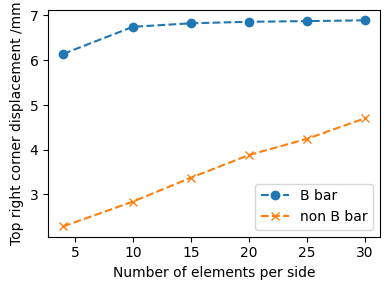

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(n_range, np.asarray(uy_top_fbar_true) * 1e3, "--o", label="B bar")
ax.plot(n_range, np.asarray(uy_top_fbar_false) * 1e3, "--x", label="non B bar")
ax.set_xlabel("Number of elements per side")
ax.set_ylabel("Top right corner displacement /mm")
ax.legend()
fig.tight_layout()

### Comparison of results
The contour plots show that even with the coarsest mesh, the F bar method still gives reasonable stress result.

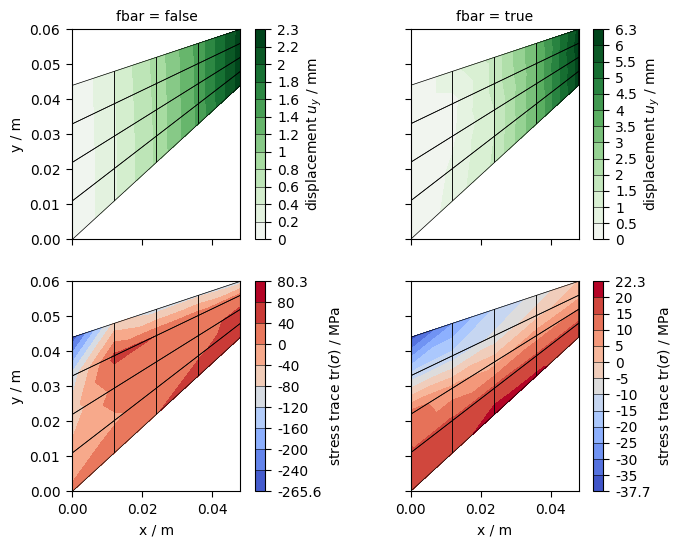

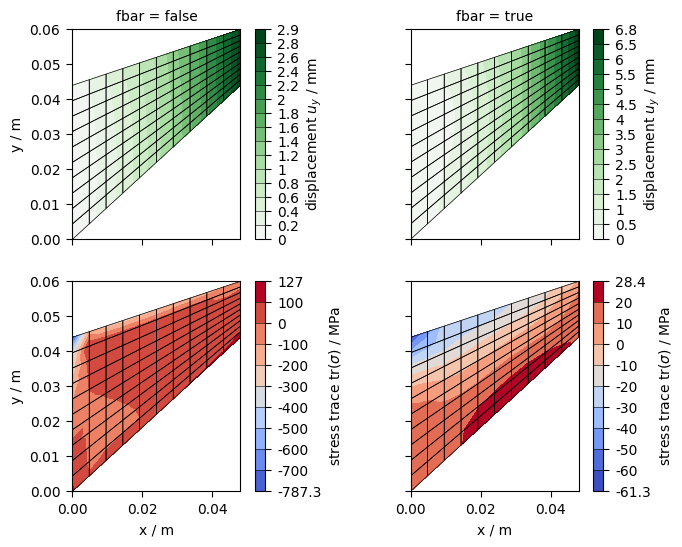

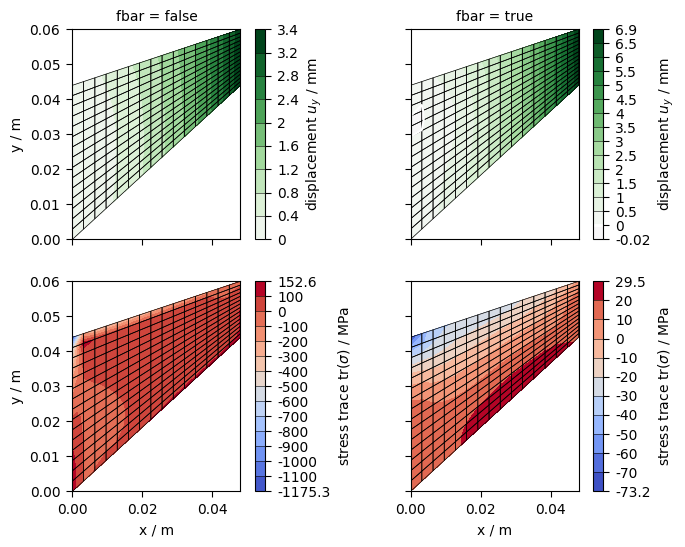

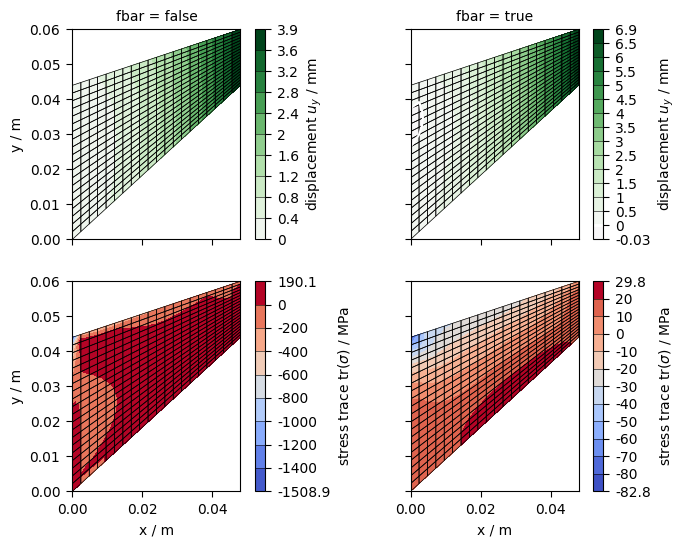

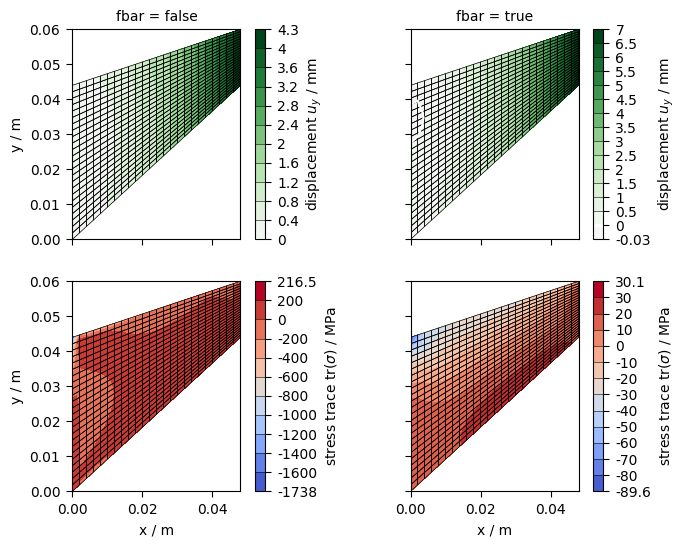

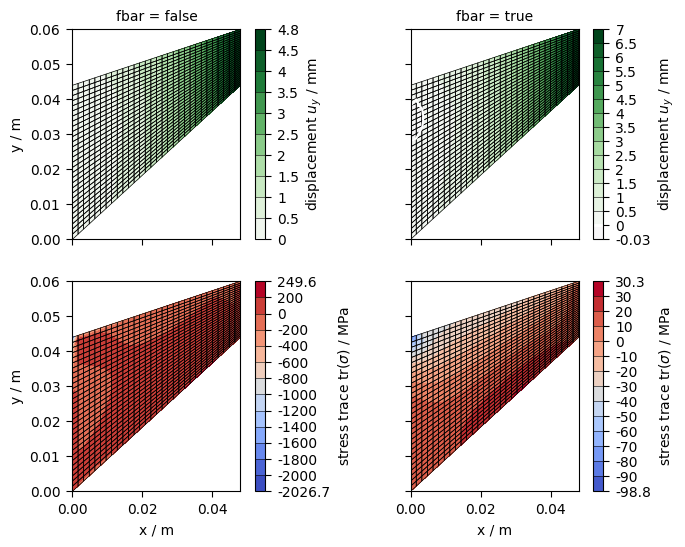

In [6]:
for n in n_range:
    compare(results_fbar_false[n][-1], results_fbar_true[n][-1])

## Reference

1. E.A. de Souza Neto, D. Perić, M. Dutko, D.R.J. Owen, [Design of simple low order finite elements for large strain analysis of nearly incompressible solids](https://doi.org/10.1016/0020-7683(95)00259-6), International Journal of Solids and Structures, Volume 33, Issues 20–22, 1996, Pages 3277-3296.

2. T. Elguedj, Y. Bazilevs, V.M. Calo, T.J.R. Hughes (2008),
 $\bar\B$ and $\bar{\text F}$ projection methods for nearly incompressible linear and non-linear elasticity and plasticity using higher-order NURBS elements, Computer Methods in Applied Mechanics and Engineering, 197(33–40), 2732-2762.
